In [7]:
import numpy as np
from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
from aniposelib.utils import load_pose2d_fnames
import toml

In [5]:
vidnames = [['calib-charuco-camA-compressed.MOV'],
            ['calib-charuco-camB-compressed.MOV'],
            ['calib-charuco-camC-compressed.MOV']]

cam_names = ['A', 'B', 'C']

n_cams = len(vidnames)

board = Checkerboard(6, 9,
                     square_length=25, # here, in mm but any unit works
                     )


# the videos provided are fisheye, so we need the fisheye option
cgroup = CameraGroup.from_names(cam_names, fisheye=True)



In [ ]:
# this will take about 15 minutes (mostly due to detection)
# it will detect the charuco board in the videos,
# then calibrate the cameras based on the detections, using iterative bundle adjustment
cgroup.calibrate_videos(vidnames, board)

# if you need to save and load
# example saving and loading for later
cgroup.dump('calibration.toml')

calib-charuco-camA-compressed.MOV


 32%|████████▌                  | 1666/5274 [08:30<2:06:53,  2.11s/it]

In [6]:
## example of loading calibration from a file
## you can also load the provided file if you don't want to wait 15 minutes
cgroup = CameraGroup.load('calibration.toml')


AttributeError: module 'toml' has no attribute 'load'

In [6]:
## example triangulation without filtering, should take < 15 seconds
fname_dict = {
    'A': '2019-08-02-vid01-camA.h5',
    'B': '2019-08-02-vid01-camB.h5',
    'C': '2019-08-02-vid01-camC.h5',
}

d = load_pose2d_fnames(fname_dict, cam_names=cgroup.get_names())

score_threshold = 0.5

n_cams, n_points, n_joints, _ = d['points'].shape
points = d['points']
scores = d['scores']

bodyparts = d['bodyparts']

# remove points that are below threshold
points[scores < score_threshold] = np.nan

points_flat = points.reshape(n_cams, -1, 2)
scores_flat = scores.reshape(n_cams, -1)

p3ds_flat = cgroup.triangulate(points_flat, progress=True)
reprojerr_flat = cgroup.reprojection_error(p3ds_flat, points_flat, mean=True)

p3ds = p3ds_flat.reshape(n_points, n_joints, 3)
reprojerr = reprojerr_flat.reshape(n_points, n_joints)


100%|█████████████████████████| 87900/87900 [00:09<00:00, 9103.90it/s]


<IPython.core.display.Javascript object>


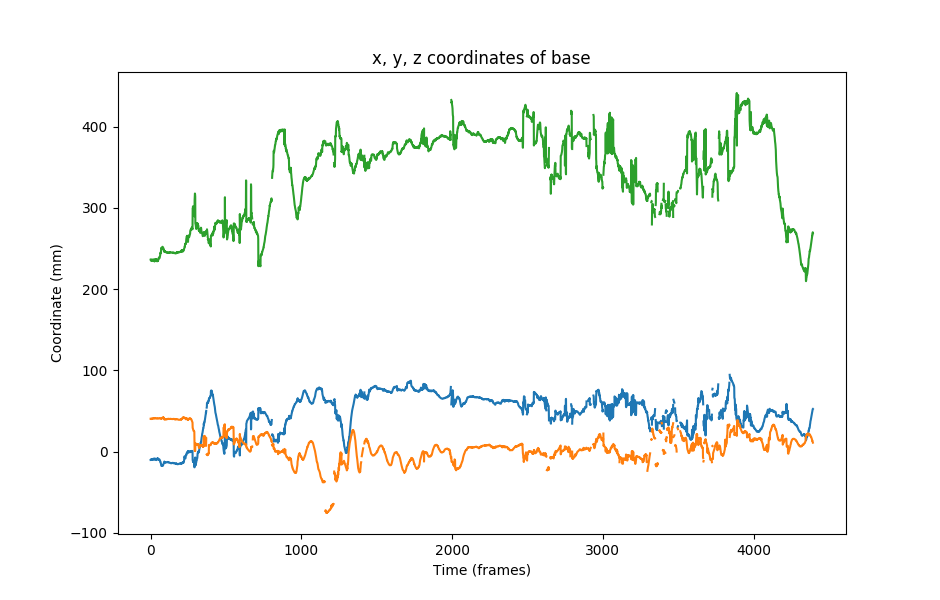

Text(0.5, 1.0, 'x, y, z coordinates of base')

In [26]:
# plot the x, y, z coordinates of joint 0

import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(9.4, 6))
plt.plot(p3ds[:, 0, 0])
plt.plot(p3ds[:, 0, 1])
plt.plot(p3ds[:, 0, 2])
plt.xlabel("Time (frames)")
plt.ylabel("Coordinate (mm)")
plt.title("x, y, z coordinates of {}".format(bodyparts[0]))

<IPython.core.display.Javascript object>


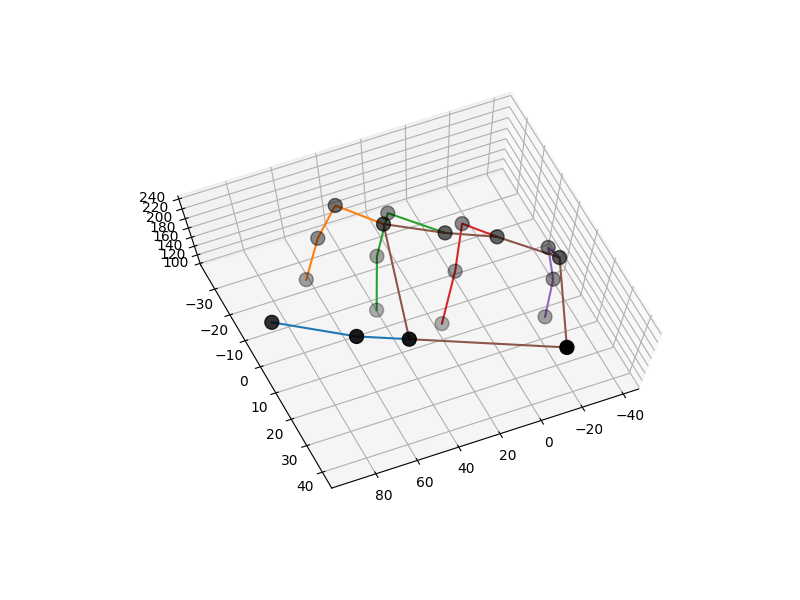

[[<mpl_toolkits.mplot3d.art3d.Line3D at 0x7f7e882341d0>],

In [25]:
## plot the first frame in 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import get_cmap
%matplotlib notebook

def connect(ax, points, bps, bp_dict, color):
    ixs = [bp_dict[bp] for bp in bps]
    return ax.plot(points[ixs, 0], points[ixs, 1], points[ixs, 2], color=color)

def connect_all(ax, points, scheme, bodyparts, cmap=None):
    if cmap is None:
        cmap = get_cmap('tab10')
    bp_dict = dict(zip(bodyparts, range(len(bodyparts))))
    lines = []
    for i, bps in enumerate(scheme):
        line = connect(ax, points, bps, bp_dict, color=cmap(i)[:3])
        lines.append(line)
    return lines

## scheme for the hand
scheme = [
   ["MCP1", "PIP1", "tip1"],
   ["MCP2", "PIP2", "DIP2", "tip2"],
   ["MCP3", "PIP3", "DIP3", "tip3"],
   ["MCP4", "PIP4", "DIP4", "tip4"],
   ["MCP5", "PIP5", "DIP5", "tip5"],
   ["base", "MCP1", "MCP2", "MCP3", "MCP4", "MCP5", "base"]
 ]

framenum = 0
p3d = p3ds[framenum]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p3d[:,0], p3d[:,1], p3d[:,2], c='black', s=100)
connect_all(ax, p3d, scheme, bodyparts)
